# Introducción al TP2- Random Forest

## Set up inicial

In [90]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

## Carga de los datasets y info

Se cargan las columnas con formatos adecuados según el tipo de datos. Se usa como índice building_id

In [91]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")
columnas = train_values.columns.to_list()

In [92]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [93]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [94]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

In [95]:
train_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [96]:
# Se seleccionan las columnas que vamos a usar para entrenar el modelo.
# Podemos usar todas, algunas, crear nuevas, etc.
# Para correr esta vez vamos a usar pocas para que corra rápido
# Notar que foundation_type es categórica. No se puede usar en RF variables categóricas. Hay que encodearlas como vemos mas adelante
selected_features = ['geo_level_1_id',
                     'geo_level_2_id',
                     'geo_level_3_id',
                     'count_floors_pre_eq',
                     'age',
                     'area_percentage',
                     'height_percentage',
                     'foundation_type',
                     ]
train_values_subset = train_values[selected_features]

In [97]:
train_values_subset.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,foundation_type
building_id,,,,,,,,
802906,6,487,12198,2,30,6,5,r
28830,8,900,2812,2,10,8,7,r
94947,21,363,8973,2,10,5,5,r
590882,22,418,10694,2,10,6,5,r
201944,11,131,1488,3,30,8,9,r


In [98]:
train_values_subset['foundation_type'].value_counts()

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

## Preprocesamiento de los datos

In [99]:
## Convierte las variables categóricas en columnas booleanas a 0 o 1. Se le llama One-Hot-Encoding(En los videos de Feature Engineering para más info)
## Por ej foundation_type tiene 5 tipos: r, w, u. i,h Se crean 5 columnas para cada registro y según sea su foundation_type va a tener 1 en la respectiva columna y 0 en las otras 2.
train_values_subset = pd.get_dummies(train_values_subset)

In [100]:
## Por ejemplo el primer edificio de building_id 802906 era de foundation_type 'r', entonces en la columna foundation_type_r tendrá un 1 (y solo en esa).
train_values_subset.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w
building_id,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,0,0,1,0,0
28830,8,900,2812,2,10,8,7,0,0,1,0,0
94947,21,363,8973,2,10,5,5,0,0,1,0,0
590882,22,418,10694,2,10,6,5,0,0,1,0,0
201944,11,131,1488,3,30,8,9,0,0,1,0,0


## Creacion de Modelo de ML (Random Forest)

In [101]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

# Para ver los parametros que se utilizan
from pprint import pprint

Armado de pipeline

In [102]:
## Un pipeline es como una máquina que recibe intrucciones y las ejecuta de manera secuencial
## Aca le digo que normalice los valores con StandardScaler(), y que luego apliquemos un clasificador de Random Forest.
## El random state pueden ponerle cualquier valor, solo para que siempre corra de la misma manera. También se le conoce como semilla (seed)
## Max Depth es la máxima profundidad del arbol.
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=99,max_depth=None))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=99))])

Vemos la configuración de los hiper-parámetros

In [103]:
## Como vimos en la teórica, hay que decirle al arbol los hiperparámetros. El problema es que no sabemos.
## Por lo tanto, nos ponemos a probar. En este caso utilizo de 80 a 150 arboles y las hojas tienen al menos de 3 a 8 hojas.
## Prueba las combinaciones de estos hiperparámetros. Hay más hiperparámetros para tunear, pero estos son los más importantes.
param_grid = {'randomforestclassifier__n_estimators': [80, 150],
              'randomforestclassifier__min_samples_leaf': [3, 8],
             }
pprint(param_grid)

{'randomforestclassifier__min_samples_leaf': [3, 8],
 'randomforestclassifier__n_estimators': [80, 150]}


Creo el tablero con los parámetros indicados

In [106]:
## GridSearchCV es el "tablero" donde vamos a probar todas las combinaciones
## Además, el CV indica que vamos a hacer cross-validation. 
## Es decir, se parte el dataset en k bloques y se hacen k iteraciones del modelo pero usando a 1 bloque como set de test y k-1 como entrenamiento
## En este caso cv=5, divide al set en 5 bloques, y se va a dejar en cada iteración uno como set de test.
## Nos vamos a quedar con el arbol que mejor resultados nos haya dado

## Si quieren que vaya mas rapido, cambien n_jobs a la cantidad de nucleos de su PC que quieren usar.
gs = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1)

Busqueda de los parámetros - Tarda alrededor de 2 minutos

In [107]:
## gs.fit el la orden de ejecutar el modelo. En general siempre vamos a hacer modelo.fit()
## Le pasamos el dataset de entrenamiento, es decir todos los features sin los labels (daños), y por otro lado los labels.
gs.fit(train_values_subset, train_labels.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=99))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__min_samples_leaf': [3, 8],
                         'randomforestclassifier__n_estimators': [80, 150]})

In [108]:
## Nos muestra los hiperparámetros que mejor resultado le dieron
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 3,
 'randomforestclassifier__n_estimators': 150}

In [109]:
## Metrica que utilizamos en DrivenData
## Dato (No es importante): Esta métrica valora más que predigas los datos generales que los más específicos
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.8353306395600938

## Guardar el modelo para no tener que entrenar de vuelta

Guardamos el modelo

In [110]:
import pickle
filename = 'random_forest_modelo1.sav'

In [111]:
## Podemos guardar el modelo en un archivo para no tener que hacer gs.fit de vuelta.
## Si queremos cambiar los features, hiperparámetros, etc. No queda otra que hacerlo de nuevo
pickle.dump(gs, open(filename, 'wb'))

Cargar el modelo

In [85]:
gs = pickle.load(open(filename, 'rb'))

Ejemplo de que funciona como antes

In [112]:
from sklearn.metrics import f1_score
in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.8353306395600938

Se puede graficar 

In [87]:
rf = gs.best_estimator_.named_steps["randomforestclassifier"]
len(rf.estimators_)

150

In [88]:
from sklearn import tree
tree0 = rf.estimators_[0]
tree0.tree_.max_depth

3

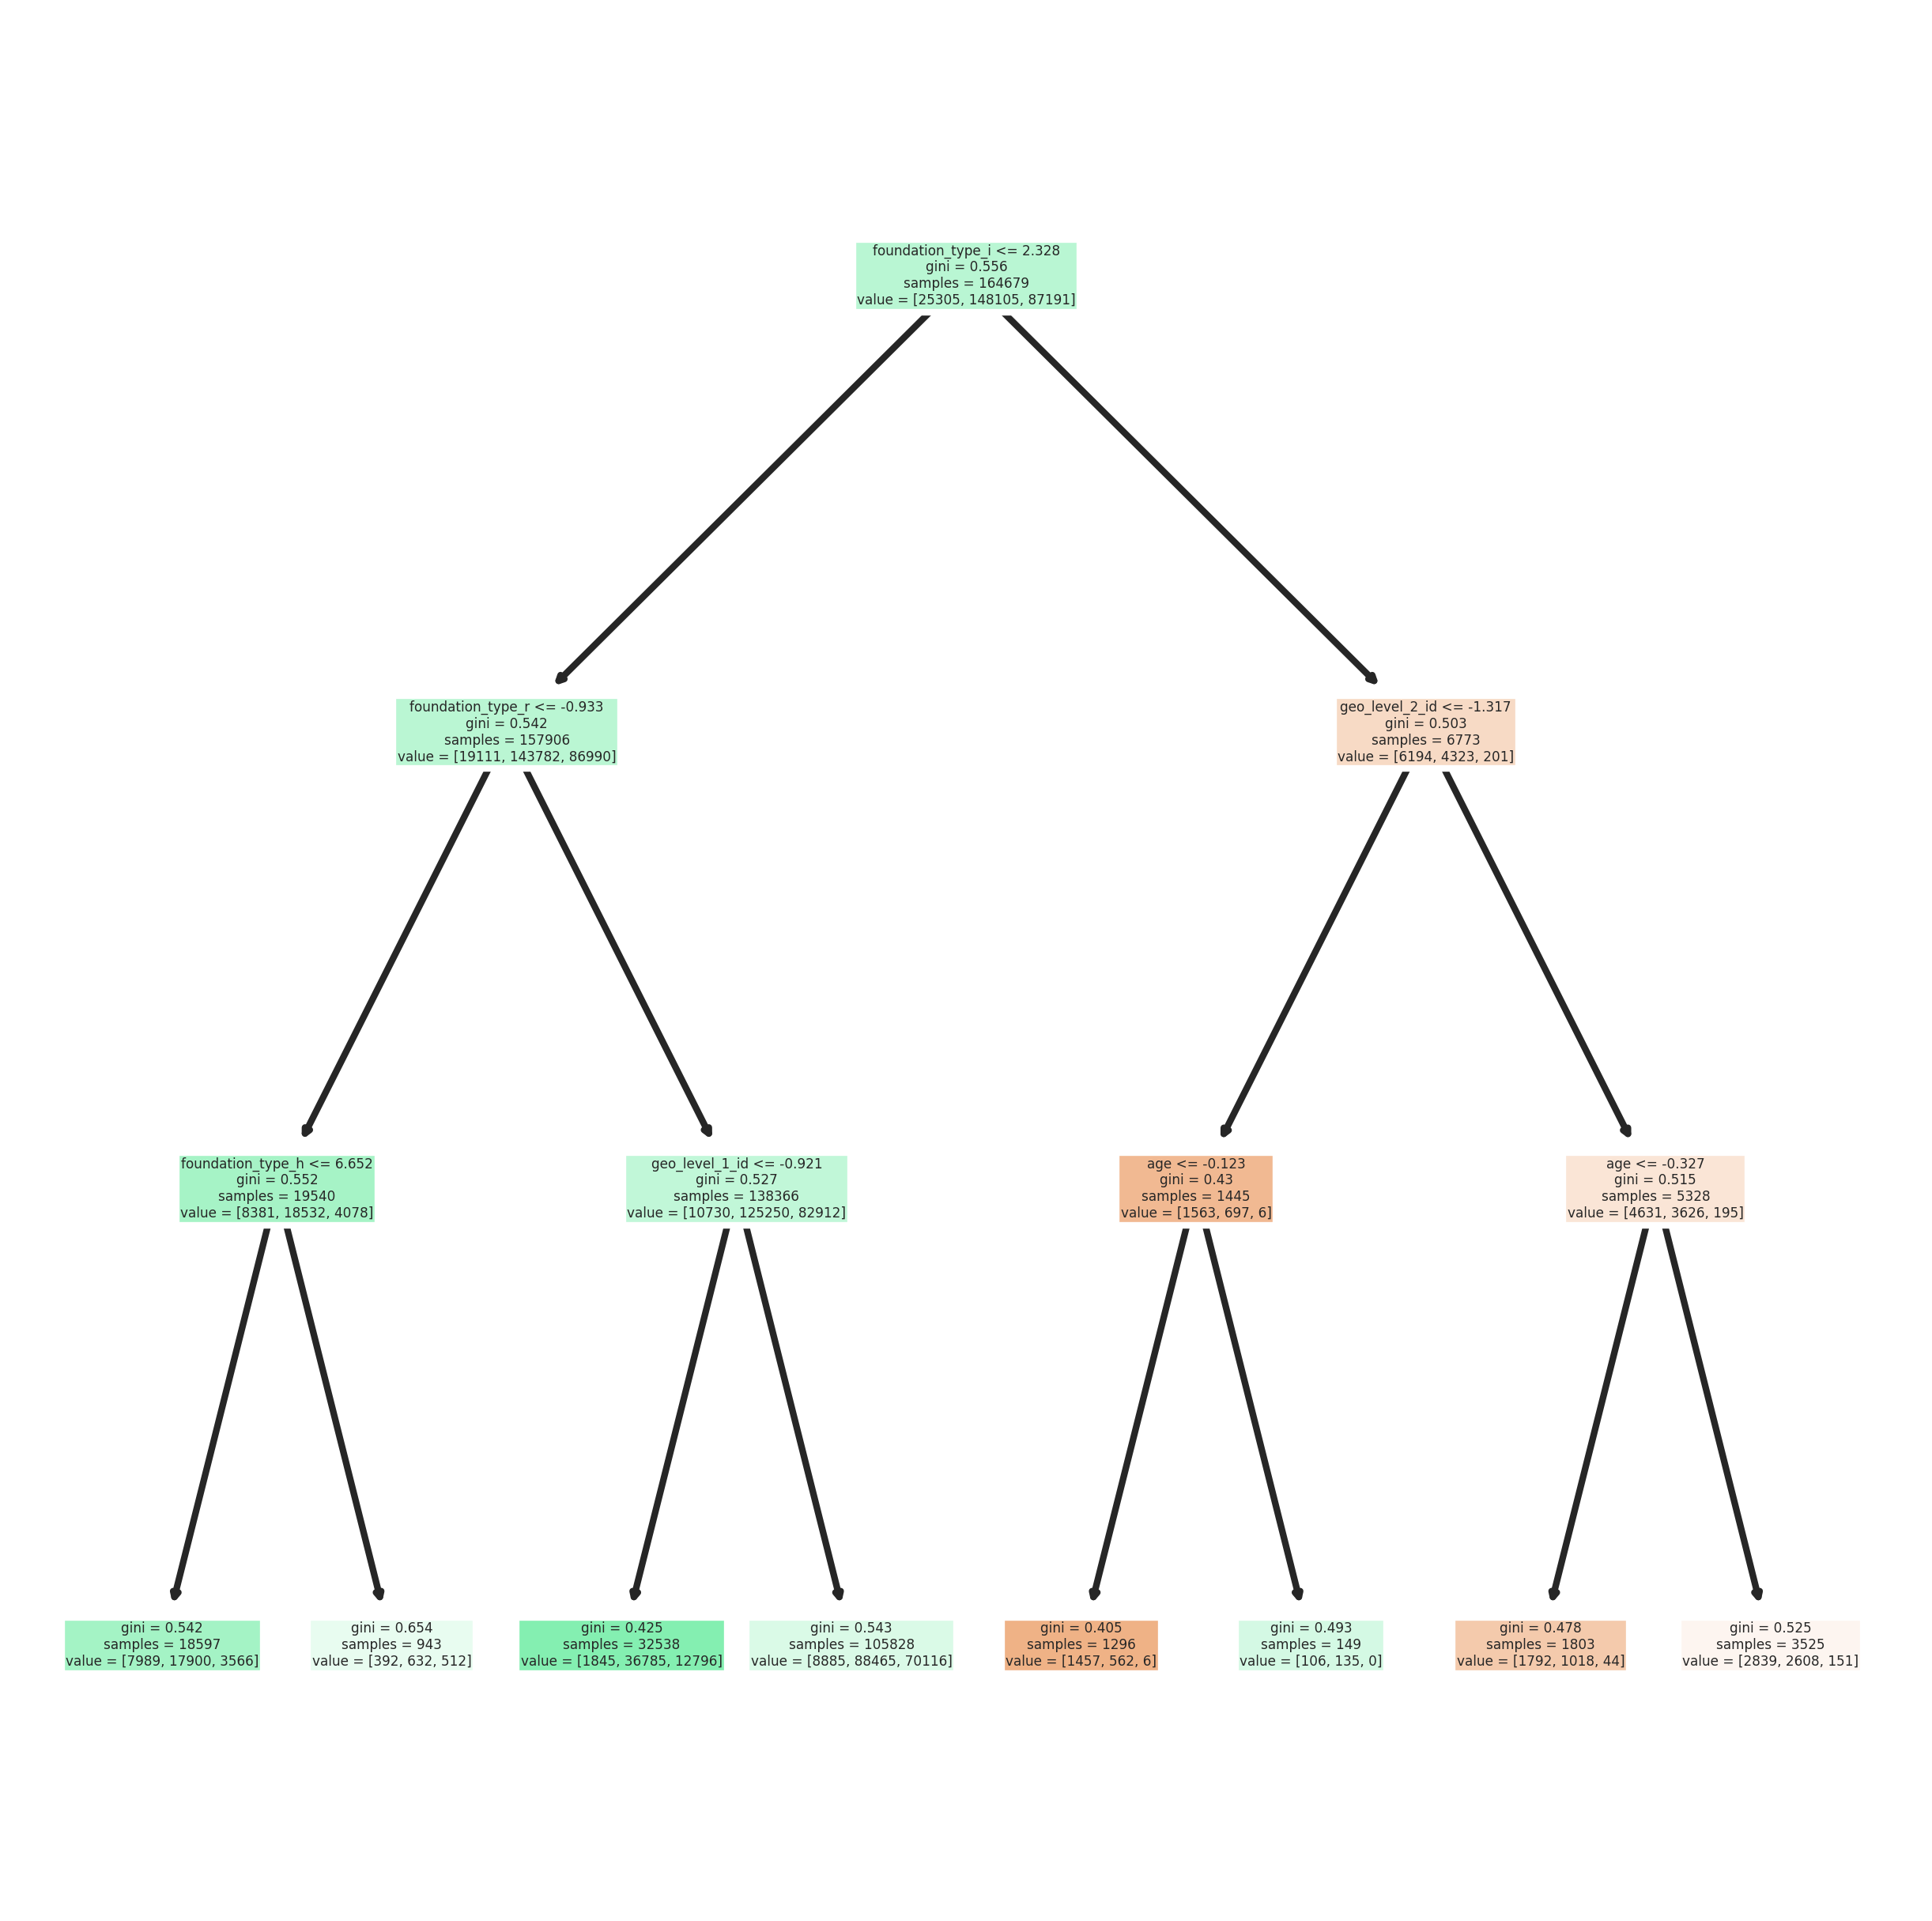

In [89]:
fig, axes = plt.subplots(figsize = (5,5),dpi=600)
tree.plot_tree(tree0,
               feature_names = train_values_subset.columns,
               filled = True);

## Predecir el set de test de DrivenData

Tenemos que predecir nuevos valores de los que desconocemos sus labels o daños.  
Solo tenemos sus columnas o features. Vamos a utilizar nuestro modelo para predecir.

In [47]:
test_values = pd.read_csv('datos/test_values.csv', index_col='building_id')

In [48]:
test_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


El set de test tiene que tener el MISMO formato que usamos para entrenar.  
Es decir, si le hicimos algunas modificaciones en las columnas al set de entrenamiento, también tenemos que hacerlas al set de test.  
En este caso, solo seleccionamos algunas columnas y utilizamos One-Hot-Encoding para las variables categóricas (get_dummiesget_dummies)

In [50]:
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)

Predecimos con gs.predict. Le pasamos los valores del set de test.

In [51]:
predictions = gs.predict(test_values_subset)

Guardamos el submit. Lo pasamos a Pandas y de ahí a CSV (por tema de formato).  
Esto es lo que se sube a la página de DrivenData

In [52]:
submission_format = pd.read_csv('datos/submission_format.csv', index_col='building_id')

In [53]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [54]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [58]:
my_submission.to_csv('submission.csv')

Una mirada adentro del csv

In [59]:
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2
